<h1> ML (VANILLA & DL)

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore')

/Users/glebcom/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Preprocessing

## Drawing

In [2]:
def trace_nodes(g, nodes_split):
    node_text = [f'{node} {coord}' for node, coord in zip(nx.get_node_attributes(g, 'coords').keys(), nx.get_node_attributes(g, 'coords').values())]

    coords = nx.get_node_attributes(g, 'coords')
    colorscale = ['lightgreen', 'magenta']

    trace_nodes = go.Scatter3d(x=[coords[i][0] for i in coords.keys()],
                               y=[coords[i][1] for i in coords.keys()],
                               z=[coords[i][2] for i in coords.keys()],
                               mode='markers',
                               marker=dict(symbol='circle', size=5,color=nodes_split, colorscale=colorscale),
                               opacity=0.5,
                               text=node_text, hoverinfo='text')

    return trace_nodes

In [3]:
def trace_edges(g):
    coords = nx.get_node_attributes(g, 'coords')

    x_edges=[]
    y_edges=[]
    z_edges=[]

    for edge in g.edges():
        x_coords = [coords[edge[0]][0],coords[edge[1]][0],None]
        x_edges += x_coords

        y_coords = [coords[edge[0]][1],coords[edge[1]][1],None]
        y_edges += y_coords

        z_coords = [coords[edge[0]][2],coords[edge[1]][2],None]
        z_edges += z_coords

    trace_edges = go.Scatter3d(x=x_edges, y=y_edges, z=z_edges,
                               mode='lines',
                               line=dict(color='rgba(74, 54, 54, 1)', width=2),
                               hoverinfo='none')
    
    return trace_edges

In [4]:
def draw_cube(cube_dim):
    x = [0, cube_dim, cube_dim, 0, 0]
    y = [0, 0, cube_dim, cube_dim, 0]
    z1 = [0, 0, 0, 0, 0]
    z2 = [cube_dim, cube_dim, cube_dim, cube_dim, cube_dim]

    trace = []
    e_color = 'rgba(185, 75, 75, 0.5)'

    # trace top and bottom
    trace.append(go.Scatter3d(x=x, y=y, z=z1, mode='lines', line=dict(color=e_color, width=2), hoverinfo='none'))
    trace.append(go.Scatter3d(x=x, y=y, z=z2, mode='lines', line=dict(color=e_color, width=2), hoverinfo='none'))

    # trace 4 vertical lines
    for i in range(4):
        trace.append(go.Scatter3d(x=[x[i],x[i]], y=[y[i],y[i]], z=[z1[0],z2[0]], mode='lines', line=dict(color=e_color, width=2), hoverinfo='none'))

    return trace

In [5]:
def draw_main_circuit(g):
    data = []
    data.extend(draw_cube(cube_dim=0.5))
    node_colorscale = [1 if g.nodes[n]['type']=='r' else 0 for n in g.nodes()]
    data.append(trace_nodes(g, node_colorscale))
    data.append(trace_edges(g))

    axis = dict(showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False, title='')
    layout = go.Layout(title="3D grid circuit",
                       width=650, height=625,
                       showlegend=False,
                       scene=dict(xaxis=dict(axis), yaxis=dict(axis), zaxis=dict(axis)),
                       margin=dict(t=100),
                       hovermode='closest')

    fig = go.Figure(data=data, layout=layout)
    fig.show()

## Data

In [30]:
# data_path = '/Users/glebcom/Desktop/skoltech/research/nb/data'
# labels_path = '/Users/glebcom/Desktop/skoltech/research/nb/data/df_labels.csv'

# data = cnt_data(data_path, labels_path, save_to='df_full.csv', update=False)
# df = data.df

df = pd.read_csv('/Users/glebcom/Desktop/skoltech/research/ncfd/dataframes/df_grid2_r08_h01.csv', index_col=0)

In [31]:
df.shape

(1599, 280)

`StandardScaler`
$$z = \frac{(x - mean)}{std}$$

`MinMaxScaler`
$$std = \frac{X - min}{max - min}$$
$$z = std \times (max - min) + min$$

In [13]:
def df_transform(df):
    df_scaled = df.copy(deep=True)
    
#     m = np.mean(df_scaled.iloc[-1, :-4])
#     std = np.std(df_scaled.iloc[-1, :-4])
    
#     df_scaled.iloc[:-1, :-4] = (df_scaled.iloc[:-1, :-4] - m) / std
    
    for idx in df.index[:-1]:
        df_scaled.iloc[idx, :-4] = df_scaled.iloc[idx, :-4] / df_scaled.iloc[-1, :-4]
    
    return df_scaled

In [13]:
# df_scaled = df_transform(df)

In [14]:
# X = df_scaled[df_scaled.columns[:-4]].iloc[:-1] #.to_numpy())
# y = df_scaled[df_scaled.columns[-3:]].iloc[:-1] #.to_numpy()

In [32]:
X = df[df.columns[:-4]].iloc[:-1]
y = df[df.columns[-3:]].iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    shuffle=True, random_state=42)

In [33]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()

# scaler.fit(df[df.columns[:-4]].iloc[[-1]])

# X = scaler.transform(df[df.columns[:-4]].iloc[:-1]) #.to_numpy())
# y = df[df.columns[-3:]].iloc[:-1] #.to_numpy()

# X = df_scaled[df_scaled.columns[:-4]].iloc[:-1] #.to_numpy())
# y = df_scaled[df_scaled.columns[-3:]].iloc[:-1] #.to_numpy()

# scaler = Normalizer()

# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [34]:
print(f'X train shape: {X_train.shape}\nX test shape: {X_test.shape}')

X train shape: (1358, 276)
X test shape: (240, 276)


# Vanilla models

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA

In [36]:
def distance_score(p, phat):
    sq_sum = np.sum((p-phat)**2)
    return np.sqrt(sq_sum)

In [37]:
# rand_forest = Pipeline([
#     ('3th power', PolynomialFeatures(degree=3)),
#     ('Random Proj', GaussianRandomProjection(n_components=7, random_state=42)),
#     ('3th power 2', PolynomialFeatures(degree=3)),
#     ('Random Forest', RandomForestClassifier(max_depth=4, n_estimators=20, random_state=42))
# ])
# log_reg = Pipeline([
#     ('Proj', GaussianRandomProjection(n_components=5, random_state=400)),
#     ('4th power', PolynomialFeatures(4)),
#     ('PCA', PCA(n_components=10)),
#     ('Log Reg', LogisticRegression(penalty='l2', C=0.7, solver='lbfgs'))
# ])

In [38]:
def pred(X_train, y_train, X_test, model, params, scorer_func, draw=True):
    # pipe_model = Pipeline(steps=[('reg', MultiOutputRegressor(model))])
    # pipe_model = Pipeline(steps=[('reg', RegressorChain(model))])
    
    pipe_model = Pipeline([
        #('Proj', GaussianRandomProjection(n_components=5, random_state=42)),
        #('PCA', PCA(n_components=10)),
        #('3rd power', PolynomialFeatures(3)),
        #('norm', Normalizer()),
        ('reg', MultiOutputRegressor(model))
    ])

    gs = GridSearchCV(estimator=pipe_model,
                      param_grid=params,
                      cv=2,
                      scoring=scorer_func,
                      n_jobs = -1, verbose=10)
    
    gs = gs.fit(X_train, y_train)

    yhat = gs.best_estimator_.predict(X_test)

    return gs, gs.best_estimator_, yhat

In [39]:
# pipe_ = Pipeline(steps=[('scaler', MinMaxScaler()),
#                         ('reg', RegressorChain(DecisionTreeRegressor()))])
# pipe_.get_params()

In [40]:
dist_scorer = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'distance_score': make_scorer(distance_score, greater_is_better=False)
}

models = {
    'neighbors': KNeighborsRegressor(),
    'rf': RandomForestRegressor(),
    'xgboost': XGBRegressor(objective ='reg:squarederror',
                            learning_rate=0.01),
    'ada-boost': AdaBoostRegressor(random_state=42)
}

params = {
    'neighbors': {
        'reg__estimator__n_neighbors': [3, 5, 15],
        'reg__estimator__weights': ['distance']
    },
    'rf': {
        'reg__estimator__criterion': ['squared_error'],
        'reg__estimator__max_depth': [5, 7, 10],
        'reg__estimator__n_estimators': [700, 1000]
    },
    'xgboost':{
        'reg__estimator__n_estimators': [2000],
        'reg__estimator__max_depth': [5]
    },
    'ada-boost': {
        'reg__estimator__n_estimators': [200, 500, 1000],
        'reg__estimator__loss': ['linear', 'square'],
        'reg__estimator__learning_rate': [0.1, 1.0, 1.5, 2.0]
    }
}

In [41]:
m, best_estimator, yhat = pred(X_train, y_train, X_test,
                               models['xgboost'], params['xgboost'],
                               scorer_func=dist_scorer['neg_root_mean_squared_error'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/glebcom/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/glebcom/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/glebcom/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/glebcom/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

In [42]:
pd.DataFrame(m.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__max_depth,param_reg__estimator__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,82.577445,0.409165,0.023166,0.001695,5,2000,"{'reg__estimator__max_depth': 5, 'reg__estimat...",-0.069759,-0.069423,-0.069591,0.000168,1


In [43]:
best_estimator

Pipeline(steps=[('reg',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             enable_categorical=False,
                                                             gamma=None,
                                                             gpu_id=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.01,
                                                             max_delta_step=None,

In [44]:
yhat.shape

(240, 3)

In [45]:
def make_gr(y_test, yhat, n_max=20):
    y_test = y_test.to_numpy()
    yhat = yhat
    
    error_d = []

    for p,phat in zip(y_test, yhat):
        sq_sum = np.sum((p-phat)**2)
        error_d.append(np.sqrt(sq_sum))
    error_d = np.round(np.array(error_d), 4)
    
    err_idxs = np.argsort(error_d)[::-1]
    
#     test_len = len(y_test)

    gr_nodes = []
    gr_nodes.extend(
        [(i, {'coords': tuple(y_test[idx]), 'type': 'r'}) for i,idx in enumerate(err_idxs[:n_max])]) # real
    gr_nodes.extend(
        [(i+n_max, {'coords': tuple(yhat[idx]), 'type': 'h'})for i,idx in enumerate(err_idxs[:n_max])]) # hypothesis

    gr_edges = [(e, e+n_max) for e in range(n_max)]

    gr = nx.Graph()
    gr.add_nodes_from(gr_nodes)
    gr.add_edges_from(gr_edges)

    return gr

In [46]:
draw_main_circuit(make_gr(y_test, yhat));

In [47]:
def plot_dist_error_xyz(y_test, yhat, cube_dim=0.5):
    y_test = y_test.to_numpy()
    fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 5))
    fig.suptitle('Distance error distribution among axes', fontsize=24)

    for i,coord_label in zip(range(3), ['x', 'y', 'z']):
        ax = axs[i]
        
        # draw y=x line and predictions
        ax.axline([0, 0], [cube_dim, cube_dim])
        ax.scatter(x=y_test[:,i], y=yhat[:,i])
        
        ax.set(aspect='equal')
        ax.set_ylabel('predicted values (nm)', fontsize=18)
        ax.set_xlabel(f'test {coord_label} (nm)', fontsize=18)

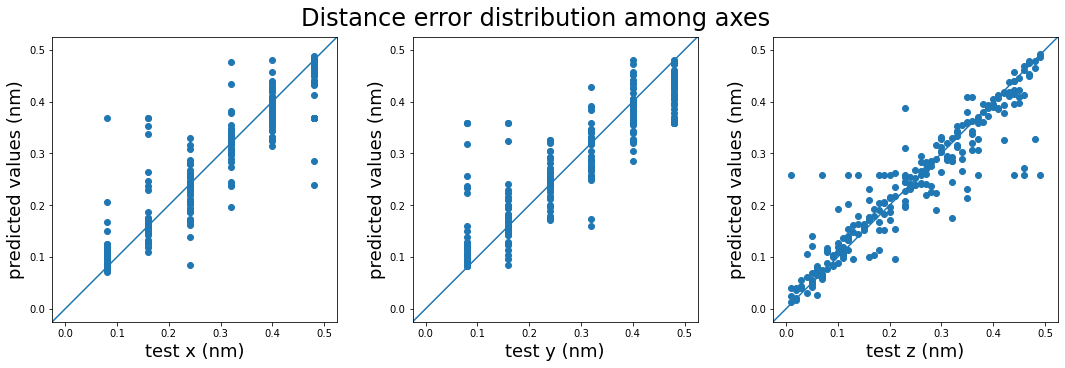

In [48]:
plot_dist_error_xyz(y_test, yhat)

Calculate distance between $p_{pred}$ and $p_{real}$

$$
d = \sqrt{\sum_{x,y,z} (p_{pred} - p_{real})^2}
$$

In [26]:
def descr(y_test, yhat):
    y_test = y_test.to_numpy()
    error_d = []
    for p,phat in zip(y_test, yhat):
        sq_sum = np.sum((p-phat)**2)
        error_d.append(np.sqrt(sq_sum))
    error_d = np.round(np.array(error_d), 4)

    print(f'mean distance: {round(np.mean(error_d),4)} +/- {round(np.std(error_d),4)}')
    print(f'min :  {np.min(error_d)}, max :  {np.max(error_d)}, Range: {np.max(error_d) - np.min(error_d)}')
    print('---')
    print(f'dist <= 0.05 (%):\t{round(len(error_d[error_d<=0.5*0.05])*100/len(error_d),2)} %')
    print(f'dist <= 0.1 (%):\t{round(len(error_d[error_d<=0.5*0.1])*100/len(error_d),2)} %')
    print(f'dist <= 0.2 (%):\t{round(len(error_d[error_d<=0.5*0.2])*100/len(error_d),2)} %')

    return error_d

    # 0.5 - 1
    # x -   0.2
    # x = 0.5*0.2

In [27]:
error_dist = descr(y_test, yhat)

mean distance: 0.0687 +/- 0.0404
min :  0.0108, max :  0.2316, Range: 0.2208
---
dist <= 0.05 (%):	9.0 %
dist <= 0.1 (%):	31.0 %
dist <= 0.2 (%):	87.0 %
[CV 2/2; 1/2] START reg__estimator__max_depth=3, reg__estimator__n_estimators=2000
[CV 2/2; 1/2] END reg__estimator__max_depth=3, reg__estimator__n_estimators=2000;, score=-0.060 total time= 1.5min
[CV 1/2; 1/2] START reg__estimator__max_depth=3, reg__estimator__n_estimators=2000
[CV 1/2; 1/2] END reg__estimator__max_depth=3, reg__estimator__n_estimators=2000;, score=-0.055 total time= 1.5min
[CV 1/2; 2/2] START reg__estimator__max_depth=5, reg__estimator__n_estimators=2000
[CV 1/2; 2/2] END reg__estimator__max_depth=5, reg__estimator__n_estimators=2000;, score=-0.059 total time= 1.6min
[CV 2/2; 2/2] START reg__estimator__max_depth=5, reg__estimator__n_estimators=2000
[CV 2/2; 2/2] END reg__estimator__max_depth=5, reg__estimator__n_estimators=2000;, score=-0.062 total time= 1.6min


In [49]:
error_dist = descr(y_test, yhat)

mean distance: 0.0769 +/- 0.0665
min :  0.005, max :  0.4626, Range: 0.4576
---
dist <= 0.05 (%):	12.08 %
dist <= 0.1 (%):	40.0 %
dist <= 0.2 (%):	81.25 %
[CV 1/2; 1/1] START reg__estimator__max_depth=5, reg__estimator__n_estimators=2000
[CV 1/2; 1/1] END reg__estimator__max_depth=5, reg__estimator__n_estimators=2000;, score=-0.070 total time= 1.4min
[CV 2/2; 1/1] START reg__estimator__max_depth=5, reg__estimator__n_estimators=2000
[CV 2/2; 1/1] END reg__estimator__max_depth=5, reg__estimator__n_estimators=2000;, score=-0.069 total time= 1.4min


In [28]:
import scipy.stats as stats
import seaborn as sns
import math

<AxesSubplot:ylabel='Density'>

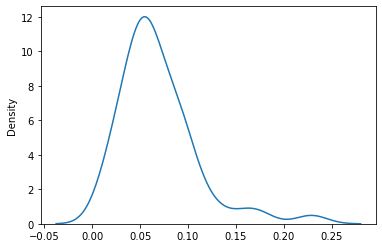

In [29]:
sns.kdeplot(error_dist)

In [184]:
def hist_dist_error(y_test, yhat, error_dist):
    plt.figure(figsize=(10,7))
    # sns.kdeplot(error_dist, color='#4a87ba')
    ax = sns.displot(error_dist, bins=int(len(error_dist)/2), kde=True, color='#388E3C');
    vline = plt.axvline(x=0.05, color='#EF9A9A')

    # plt.hist(error_dist, bins=len(error_dist), edgecolor='#ffffff', color='#46e49f')
    
    plt.xlim([0.,round(max(error_dist),2)+0.01])

    plt.title('Distance error distribution', fontsize=24)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)

<Figure size 720x504 with 0 Axes>

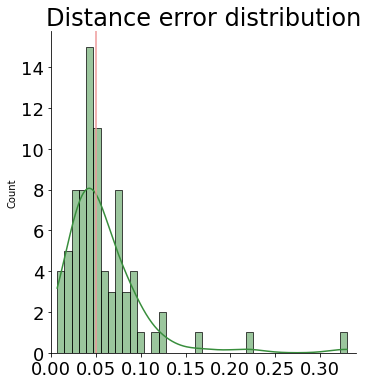

In [185]:
hist_dist_error(y_test, yhat, error_dist);

# DL

In [358]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch

import networkx as nx

# from collections import Counter

from sklearn.metrics import confusion_matrix
import seaborn as sn
import random

# from imblearn.metrics import classification_report_imbalanced

from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import torchvision.models as models

# from IPython.display import clear_output

# import cv2

# from google.colab import drive

# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# import albumentations as A

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

[CV 1/2; 3/6] START reg__estimator__max_depth=5, reg__estimator__n_estimators=1000
[CV 1/2; 3/6] END reg__estimator__max_depth=5, reg__estimator__n_estimators=1000;, score=-0.093 total time= 1.4min
[CV 1/2; 6/6] START reg__estimator__max_depth=7, reg__estimator__n_estimators=2000
[CV 1/2; 6/6] END reg__estimator__max_depth=7, reg__estimator__n_estimators=2000;, score=-0.093 total time= 1.2min
[CV 1/2; 3/6] START reg__estimator__max_depth=5, reg__estimator__n_estimators=1000
[CV 1/2; 3/6] END reg__estimator__max_depth=5, reg__estimator__n_estimators=1000;, score=-0.083 total time= 1.1min
[CV 1/2; 6/6] START reg__estimator__max_depth=7, reg__estimator__n_estimators=2000
[CV 1/2; 6/6] END reg__estimator__max_depth=7, reg__estimator__n_estimators=2000;, score=-0.083 total time= 1.0min
[CV 1/2; 3/6] START reg__estimator__max_depth=5, reg__estimator__n_estimators=1000
[CV 1/2; 3/6] END reg__estimator__max_depth=5, reg__estimator__n_estimators=1000;, score=-0.084 total time= 3.2min
[CV 1/2; 1

## CNN

In [417]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [469]:
batch_size = 8
validation_split = 0.3
shuffle_dataset = True
outp_chennels = 3
num_epochs = 3

In [470]:
learning_rate = 0.001

In [420]:
# train_set, test_set = random_split(CNTdataset, [200, 17])

# train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_set, shuffle=True)

In [423]:
train, test = train_test_split(df.iloc[:-1, :-4], test_size=0.2, random_state=seed)

In [424]:
train_sampler = SubsetRandomSampler(train.index.to_list())
valid_sampler = SubsetRandomSampler(test.index.to_list())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((3.432508856546101e-06,), (1.3494692066886702e-06,)),
])

In [425]:
class CNTdataset(Dataset):
    def __init__(self, graphs_path, labels, transform=None):
        self.graphs_path = graphs_path
        self.transform = transform
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        g_path = os.path.join(self.graphs_path,
                              self.labels.loc[index, 'g_name'])
        g = nx.read_gml(g_path)
        attr_matr = np.squeeze(np.asarray(nx.attr_matrix(g, edge_attr="U")[0]))
        label = torch.tensor(list(self.labels.loc[index, ['x', 'y', 'z']]))
        
        if self.transform is not None:
            attr_matr = self.transform(attr_matr)
        return attr_matr, label

In [426]:
graphs_path = '/Users/glebcom/Desktop/skoltech/research/nb/data/graphs'
labels = data.df.iloc[:-1, -4:]

dataset = CNTdataset(graphs_path, labels, transform)

train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           worker_init_fn=seed_worker,
                                           generator=g)

validation_loader = torch.utils.data.DataLoader(dataset, 
                                                batch_size=batch_size, 
                                                sampler=valid_sampler,
                                                worker_init_fn=seed_worker,
                                                generator=g)

In [433]:
len(validation_loader)

14

In [440]:
model = models.resnet18()
model_name = 'resnet18'

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, outp_chennels)

In [9]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, outp=3):
        super(CNN, self).__init__()
        # 216 x 216
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3, stride=1, padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.BatchNorm8 = nn.BatchNorm2d(8)
        self.BatchNorm16 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(46656, outp)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [16]:
# model = CNN(in_channels=1, outp=3).to(device)
# print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=46656, out_features=3, bias=True)
)


In [441]:
def distance_score(p, phat):
    sq_sum = torch.sum((p-phat)**2)
    return torch.sqrt(sq_sum)

In [442]:
# criterion = nn.CrossEntropyLoss()
criterion = distance_score
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [443]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([8, 1, 24, 24])


In [444]:
loss_history = []
for epoch in range(num_epochs):
    for data, targets in train_loader:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data.float())
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    loss_history.append(loss.data.item())
    if epoch%1 == 0: print(f'#{epoch} loss: {round(loss_history[-1], 4)}')

#0 loss: 1.0991
#1 loss: 0.5951
#2 loss: 0.78
#3 loss: 0.7383
#4 loss: 0.7521
#5 loss: 0.5825
#6 loss: 0.6934
#7 loss: 0.5953
#8 loss: 0.7929
#9 loss: 0.5116
#10 loss: 0.4659
#11 loss: 0.7097
#12 loss: 0.6401
#13 loss: 0.5062
#14 loss: 0.6737


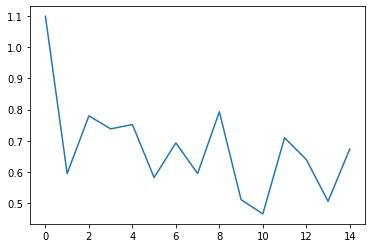

In [445]:
plt.plot(loss_history);

In [446]:
y_numpy = np.zeros((len(validation_loader)*batch_size, 3))
yhat_numpy = np.zeros((len(validation_loader)*batch_size, 3))

with torch.no_grad():
    for i, (data, target) in enumerate(validation_loader):
        x = data.to(device=device)
        y = target.to(device=device)
        yhat = model(x.float())
        
        for k, (y, yhat) in enumerate(zip(torch.squeeze(y.cpu().data).numpy(),
                                          torch.squeeze(yhat.cpu().data).numpy())):
            y_numpy[i+k] = y
            yhat_numpy[i+k] = yhat

In [447]:
y_test = y_numpy
yhat = yhat_numpy

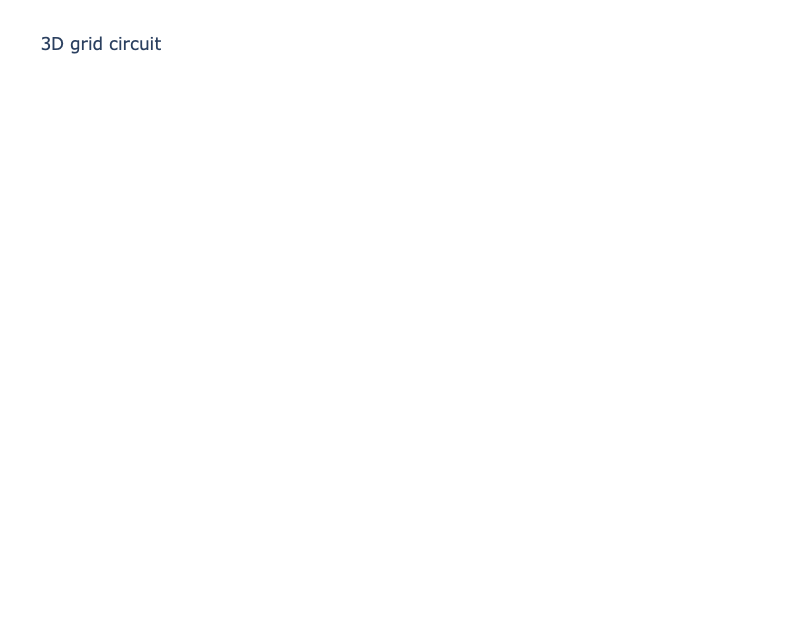

In [448]:
draw_main_circuit(make_gr(y_test, yhat))

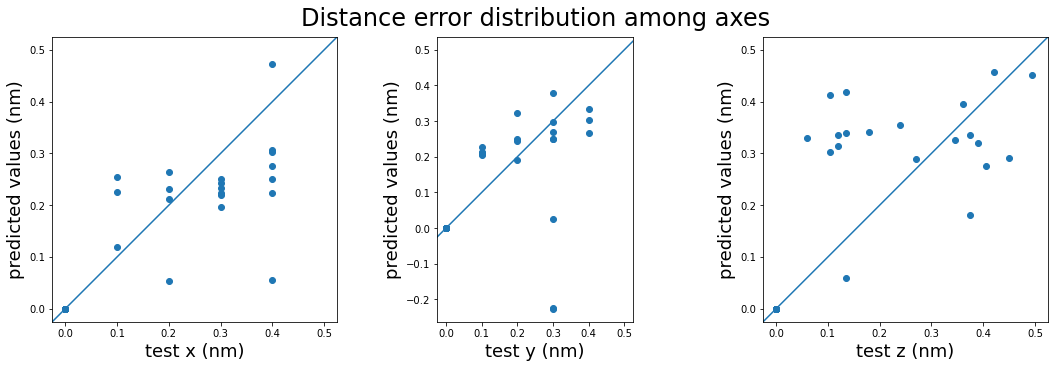

In [449]:
plot_dist_error_xyz(y_test, yhat)

In [450]:
error_dist = descr(y_test, yhat)

mean distance: 0.0445
min :  0.0, max :  0.6295, Range: 0.6295
---
dist <= 0.05:  82.14 %
dist <= 0.1:   82.14 %
dist <= 0.2:   89.29 %


<Figure size 720x504 with 0 Axes>

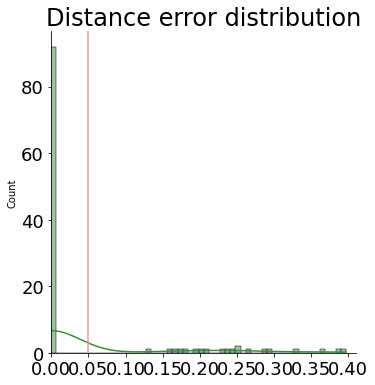

In [416]:
hist_dist_error(y_test, yhat, error_dist)

# other

In [ ]:
data = df.iloc[:, 1:-3].to_numpy()
n = 216
index = -1

X = np.zeros((n, n))
tmp = data[index]
step = n - 1
next_pos = 0
for i in range(n):
    X[i, i+1:] = tmp[next_pos:next_pos+step]
    next_pos += step
    step -= 1

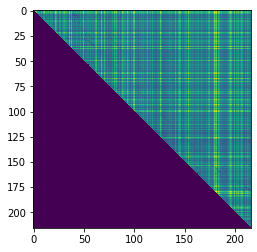

In [ ]:
plt.imshow(X, interpolation='nearest')
plt.show()

In [14]:
daa = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                    columns=['a', 'b', 'c'])
daa

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


# Feature importance

In [6]:
import os
from tqdm import tqdm

In [71]:
def fi_trace_nodes(g):
    """
    Trace nodes for main plot.
    If `sep_nodes_by_color` is True, fucntion require `nodes_split`.
    """
    node_text = [f'{n}' for n in g.nodes()]

    coords = nx.get_node_attributes(g, 'coords')
    c = 'fuchsia'
    color_scale = None

    trace_nodes = go.Scatter3d(x=[coords[i][0] for i in coords.keys()],
                               y=[coords[i][1] for i in coords.keys()],
                               z=[coords[i][2] for i in coords.keys()],
                               mode='markers',
                               marker=dict(symbol='circle', size=6, color=c, colorscale=color_scale),
                               opacity=0.5,
                               text=node_text, hoverinfo='text')

    return trace_nodes

In [72]:
def edges_coords__(coords, g_edges):
    """
    Create coordinates of edges

    Parameters
    ----------
    coords: dict
        dict of coordinates of nodes: {node: (x,y,z), ...}
    g_edges: 2d array
        Array containing edges

    Returnes
    --------
    x_edges, y_edges, z_edges: arrays
        For edges [(n1, n2), ...] arrays have form [n1_x, n2_x, None, ...]
    """
    x_edges=[]
    y_edges=[]
    z_edges=[]

    for edge in g_edges:
        x_coords = [coords[edge[0]][0],coords[edge[1]][0],None]
        x_edges += x_coords

        y_coords = [coords[edge[0]][1],coords[edge[1]][1],None]
        y_edges += y_coords

        z_coords = [coords[edge[0]][2],coords[edge[1]][2],None]
        z_edges += z_coords

    return x_edges, y_edges, z_edges

def fi_trace_edges(g, edges_split):
    """
    Trace edges for main plot.
    If `sep_edges_by_color` is True, fucntion require `edges_split`.
    """
    trace_edges = []

    coords = nx.get_node_attributes(g, 'coords')
    g_edges = np.array(list(g.edges()))

    colors = ['rgba(20, 20, 20, 0.3)', 'rgba(125, 57, 57, 1.)']

    for i,w in zip([0,1], [2,6]):
        x_edges, y_edges, z_edges = edges_coords__(coords, g_edges[edges_split == i])
        trace_edges.append(
            go.Scatter3d(x=x_edges, y=y_edges, z=z_edges,
                         mode='lines', line=dict(color=colors[i], width=w), hoverinfo='none')
        )
        
    return trace_edges

In [73]:
def draw_cube(cube_dim):
    """
    Draw cube which has unit dimensions [d x d x d]
    """
    d = cube_dim
    x = [0, d, d, 0, 0]
    y = [0, 0, d, d, 0]
    z1 = [0, 0, 0, 0, 0]
    z2 = [d, d, d, d, d]

    trace = []
    e_color = 'rgba(20, 20, 20, 0.9)'
    line_width = 3

    # trace top and bottom
    trace.append(go.Scatter3d(x=x, y=y, z=z1, mode='lines',
                              line=dict(color=e_color, width=line_width), hoverinfo='none'))
    trace.append(go.Scatter3d(x=x, y=y, z=z2, mode='lines',
                              line=dict(color=e_color, width=line_width), hoverinfo='none'))

    # trace 4 vertical lines
    for i in range(4):
        trace.append(
            go.Scatter3d(x=[x[i],x[i]], y=[y[i],y[i]], z=[z1[0],z2[0]], mode='lines',
                         line=dict(color=e_color, width=line_width), hoverinfo='none')
            )

    return trace

In [69]:
def trace_setup__(g, edges_colorscale):
    data = []
    data.extend(draw_cube(cube_dim=0.5))
    
    tr_nodes = fi_trace_nodes(g)
    tr_edges = fi_trace_edges(g, edges_colorscale)
    data.extend([*tr_edges, tr_nodes])
    return data


def fi_draw_one_case(g, most_imp_fs):
    
    edges_colorscale = np.array([0] * g.number_of_edges())
    for i,e in enumerate(g.edges()):
        if (f'U_{e[0]}_{e[1]}' in most_imp_fs) or (f'U_{e[1]}_{e[0]}' in most_imp_fs):
            edges_colorscale[i] = 1

    data = trace_setup__(g, edges_colorscale)

    axis = dict(showbackground=False, showline=False, zeroline=False,
                showgrid=False, showticklabels=False, title='')
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=2, z=1.2)
    )
    layout = go.Layout(title="3D grid circuit",
                       scene_camera=camera,
                       width=1080, height=1080,
                       showlegend=False,
                       scene=dict(xaxis=dict(axis), yaxis=dict(axis), zaxis=dict(axis)),
                       margin=dict(t=100),
                       hovermode='closest')

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [12]:
# ==================
# !!! DELETE sep=';'
# ==================


class cnt_data(object):
    def __init__(self, data_path, labels_path, save_to, update):
        # labels
        self.__labels = pd.read_csv(labels_path, index_col=0, sep=';')
        
        # initial graph object
        self.graph = self.__get_initial_graph(data_path)
        # dataframe with cracks + initial case
        self.df = self.__graphs2df(data_path, save_to, update)
        
    def __make_df(self, data_path):
        graphs_ids = list(self.__labels[~self.__labels.isnull().any(axis=1)].index)
        # to make initial graph last
        graphs_ids.append(self.__labels[self.__labels.isnull().any(axis=1)].index.item())
        
        feature_names = [f'U_{e[0]}_{e[1]}' for e in self.graph.edges()]
        feature_names.extend(['g_name', 'x', 'y', 'z'])

        df = pd.DataFrame(columns=feature_names)
        
        for idx in tqdm(graphs_ids):
            g_name = self.__labels.loc[idx, 'g_name']

            g = nx.read_gml(os.path.join(data_path, 'graphs', g_name))

            df.loc[idx, feature_names[:-4]] = [g.edges[e]['U'] for e in g.edges()]

            df.loc[idx, ['g_name', 'x', 'y', 'z']] = [g_name,
                                                      self.__labels.loc[idx, 'x'],
                                                      self.__labels.loc[idx, 'y'],
                                                      self.__labels.loc[idx, 'z']]

            del g
        return df
        
    def __graphs2df(self, data_path, save_to, update):
        if save_to in os.listdir(data_path) and not update:
            return pd.read_csv(os.path.join(data_path, save_to), index_col=0)
        else:
            df = self.__make_df(data_path)
            df.to_csv(os.path.join(data_path, save_to))
            return df
    
    def __get_initial_graph(self, data_path):
        # find index of initial graph in table of labels
        idx = self.__labels[self.__labels.isnull().any(axis=1)].index.item()
        
        return nx.read_gml(
            os.path.join(data_path, 'graphs', self.__labels.loc[idx, 'g_name']))

In [359]:
# data = cnt_data(data_path, labels_path, save_to='df_full.csv', update=True)

In [32]:
data_path = '/Users/glebcom/Desktop/skoltech/research/nb/data'
labels_path = '/Users/glebcom/Desktop/skoltech/research/nb/data/df_labels.csv'

data = cnt_data(data_path, labels_path, save_to='df_full.csv', update=False)
df = data.df
df_scaled = df_transform(df)

In [33]:
X = df_scaled[df_scaled.columns[:-4]].iloc[:-1] #.to_numpy())
y = df_scaled[df_scaled.columns[-3:]].iloc[:-1] #.to_numpy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=True, random_state=42)

print(f'train:\t{len(y_train)}\ntest:\t{len(y_test)}')

train:	423
test:	106


In [34]:
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators = 100))
regr_multirf = regr_multirf.fit(X, y)

no_est = 0 # index of target you want feature importance for
est = regr_multirf.estimators_[0]

features_names = X.columns
importances = est.feature_importances_
importances_idx = np.argsort(importances)[::-1]

rf_importances = pd.DataFrame(columns=['feature', 'importance'])
for i,idx in enumerate(importances_idx):
    rf_importances.loc[i, :] = [features_names[idx], importances[idx]]

In [35]:
rf_importances

,feature,importance
0,U_1062_1623,0.31968
1,U_18_1563,0.084557
2,U_169_18,0.063583
3,U_169_617,0.062328
4,U_1563_1292,0.037956
...,...,...
271,U_406_407,0.000105
272,U_617_953,0.000097
273,U_1256_953,0.000073
274,U_169_953,0.000038


In [58]:
most_imp_fs = list(rf_importances.iloc[:20].feature)

In [48]:
g = data.graph
g.nodes['406']

{'coords': [0.0, 0.380888746024737, 0.235035233519136]}

In [77]:
# fi_draw_one_case(g, most_imp_fs)

# AlexNet, ResNet, ViT ...

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
data_path = '/Users/glebcom/Desktop/skoltech/research/nb/data'

labels = pd.read_csv(f'{data_path}/df_labels.csv', index_col=0).iloc[:-1]
labels.head()

,g_name,x,y,z
0,cnt8_p0_0.gml,0.1,0.1,0.015
1,cnt8_p0_1.gml,0.1,0.1,0.030
2,cnt8_p0_2.gml,0.1,0.1,0.045
3,cnt8_p0_3.gml,0.1,0.1,0.060
4,cnt8_p0_4.gml,0.1,0.1,0.075


In [4]:
batch_size = 8
validation_split = 0.3
shuffle_dataset = True
outp_chennels = 3
n_epochs = 5

In [5]:
train, test = train_test_split(labels, test_size=0.2, random_state=seed)

In [6]:
train_sampler = SubsetRandomSampler(train.index.to_list())
valid_sampler = SubsetRandomSampler(test.index.to_list())

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((3.432508856546101e-06,), (1.3494692066886702e-06,)),
])

In [7]:
class CNTdataset(Dataset):
    def __init__(self, graphs_path, labels_path, transform=None):
        self.graphs_path = graphs_path
        self.transform = transform
        self.labels = pd.read_csv(labels_path, index_col=0).iloc[:-1]
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        g_path = os.path.join(self.graphs_path,
                              self.labels.loc[index, 'g_name'])
        g = nx.read_gml(g_path)
        attr_matr = np.squeeze(np.asarray(nx.attr_matrix(g, edge_attr="U")[0]))
        label = torch.tensor(list(self.labels.loc[index, ['x', 'y', 'z']]))
        
        if self.transform is not None:
            attr_matr = self.transform(attr_matr)
        return attr_matr, label

In [8]:
graphs_path = '/Users/glebcom/Desktop/skoltech/research/nb/data/graphs'
labels_path = '/Users/glebcom/Desktop/skoltech/research/nb/data/df_labels.csv'

dataset = CNTdataset(graphs_path, labels_path, transform)

train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           worker_init_fn=seed_worker,
                                           generator=g)

validation_loader = torch.utils.data.DataLoader(dataset, 
                                                batch_size=batch_size, 
                                                sampler=valid_sampler,
                                                worker_init_fn=seed_worker,
                                                generator=g)

In [456]:
# model = models.vgg16_bn()
# model_name = 'vgg16bn'

# model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# model.classifier[6] = nn.Linear(4096, outp_chennels)


model = models.resnet18()
model_name = 'resnet18'

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, outp_chennels)

In [457]:
# print(model)

In [480]:
def epoch_train(loader, model, criterion, opt):
    model.train()

    train_loss = 0
    #correct = 0
    #total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()

        train_loss += loss.item()

        #_, predicted = outputs.max(1)
        #total += labels.size(0)
        #correct += predicted.eq(labels).sum().item()

    return train_loss/len(loader)#, correct / total

def epoch_test(loader, model, criterion):
    model.eval()

    valid_loss = 0
    #correct=0
    #total=0

    with torch.no_grad():
        errors = []
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            
            error_d = []
            for p,phat in zip(labels.numpy(), outputs.numpy()):
                sq_sum = np.sum((p-phat)**2)
                error_d.append(np.sqrt(sq_sum))
            error_d = np.round(np.array(error_d), 4)
            
            errors.extend(error_d)
            #_, predicted = outputs.max(1)
            #total += labels.size(0)
            #correct += predicted.eq(labels).sum().item()

    return valid_loss/len(loader), np.array(errors)

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=3):
    tr_acc, ts_acc = [], []
    tr_loss, ts_loss = [], []

    for epoch in tqdm(range(n_epochs)):
        train_loss = epoch_train(train_loader, clf, criterion, opt)
        test_loss, errors = epoch_test(test_loader, clf, criterion)
        print(f'dist <= 0.05:  {round(len(errors[errors<=0.05])*100/len(errors),2)} %')

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; ' + 
              f'test loss: {test_loss:.3f}')
        
        #tr_acc.append(train_acc)
        tr_loss.append(train_loss)

        #ts_acc.append(test_acc)
        ts_loss.append(test_loss)

    return tr_loss, ts_loss

In [481]:
print('Number of weights:', np.sum([np.prod(p.shape) for p in model.parameters()]))

Number of weights: 11171779


In [482]:
opt = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

model = model.to(device)

loss_tr, loss_ts = train(train_loader, validation_loader, model, criterion, opt, n_epochs=num_epochs)

 33%|███████████████                              | 1/3 [00:10<00:21, 10.70s/it]

dist <= 0.05:  0.0 %
[Epoch 1] train loss: 0.826; test loss: 0.806


 67%|██████████████████████████████               | 2/3 [00:21<00:10, 10.55s/it]

dist <= 0.05:  0.0 %
[Epoch 2] train loss: 0.810; test loss: 0.832


100%|█████████████████████████████████████████████| 3/3 [00:31<00:00, 10.51s/it]

dist <= 0.05:  0.0 %
[Epoch 3] train loss: 0.816; test loss: 0.826


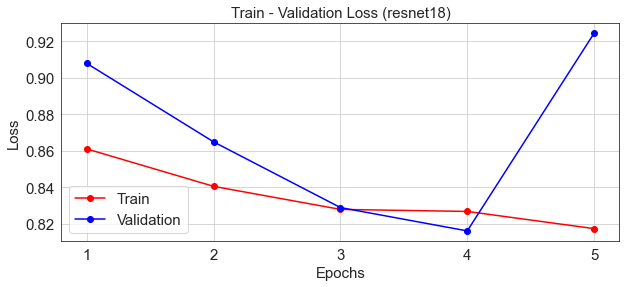

In [468]:
fig = plt.figure(figsize=(10,4))
sn.set_style('white')
plt.title(f'Train - Validation Loss ({model_name})', fontsize=15)
plt.plot(range(1, n_epochs+1), loss_tr, '-o', label='Train', c='red')
plt.plot(range(1, n_epochs+1), loss_ts, '-o',  label='Validation', c='blue')
plt.xlabel('Epochs', fontsize=15)
plt.xticks(range(1, n_epochs+1), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid()

In [ ]:
# class ToTensor(object):
#     """
#     Convert ndarrays in sample to Tensors
#     """

#     def __call__(self, sample):
#         data, y = sample['data'], sample['y']
#         return {'data': torch.from_numpy(data).unsqueeze(0),
#                 'y': torch.from_numpy(y)}

# # in-memory dataset
# class CompositeDataset(Dataset):
#     def __init__(self, df, nodes_on_surface, transform=None):
#         self.data = df.iloc[:, 1:-3].to_numpy()
#         self.labels = df.iloc[:, -3:].to_numpy()
#         self.__n = nodes_on_surface
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         X = np.zeros((self.__n, self.__n))
#         tmp = self.data[index]
#         step = self.__n - 1
#         next_pos = 0
#         for i in range(self.__n):
#             X[i, i+1:] = tmp[next_pos:next_pos+step]
#             next_pos += step
#             step -= 1

#         y = self.labels[index]

#         sample = {'data': X, 'y': y}

#         if self.transform:
#             sample = self.transform(sample)
#         return sample